## Import Statements

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

## Device Configuration

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")

Device : cuda


## Data Prep

Download Training Data and split it into trainset and validationset in the ratior 0.8 : 0.2

In [3]:
# batch size for training
batch_size = 64

# define transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize image to [-1, 1]

train_data = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Define the size of the validation dataset (20% of the total dataset)
validation_size = int(0.2 * len(train_data))
training_size = len(train_data) - validation_size

# Split the dataset into training and validation sets
training_set, validation_set = random_split(train_data, [training_size, validation_size])

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2)
# 10 classes in total
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 41943313.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Test Set

In [4]:
# load test data (note that the data has been transformed already)
test_images = torch.load('./test_image.pt')

## Take a look at your image data

torch.Size([64, 3, 32, 32]) tensor([8, 5, 7, 1, 1, 4, 2, 6, 2, 7, 5, 0, 0, 7, 9, 2, 7, 4, 8, 4, 3, 6, 1, 8,
        7, 0, 7, 8, 8, 3, 9, 4, 8, 2, 8, 0, 3, 1, 4, 9, 0, 7, 2, 6, 6, 4, 4, 7,
        0, 1, 7, 3, 2, 4, 5, 9, 9, 7, 4, 5, 0, 4, 6, 2])


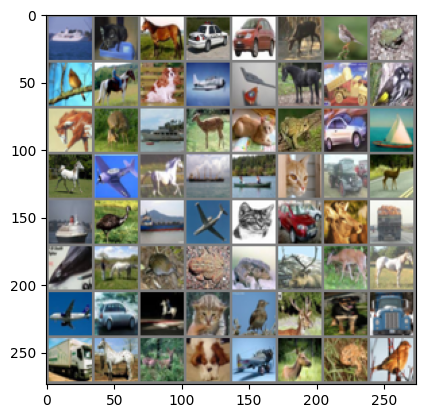

ship  dog   horse car   car   deer  bird  frog  bird  horse dog   plane plane horse truck bird  horse deer  ship  deer  cat   frog  car   ship  horse plane horse ship  ship  cat   truck deer  ship  bird  ship  plane cat   car   deer  truck plane horse bird  frog  frog  deer  deer  horse plane car   horse cat   bird  deer  dog   truck truck horse deer  dog   plane deer  frog  bird 


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get a random batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape, labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## CNN model


In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 10)  # 10 classes for CIFAR-10
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = CNN()

## Optimizer and Loss Function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Training Loop

In [8]:
train_losses = []  # Store training losses
val_losses = []  # Store validation losses

model.to(device)

total_epoch = 50
for epoch in range(total_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data, target in train_loader:
        # move data and target to the same device as the model
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * data.size(0)

    # Validate the model
    model.eval()
    for valid_data, valid_target in valid_loader:
        # move data and target to the same device as the model
        valid_data, valid_target = valid_data.to(device), valid_target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        valid_output = model(valid_data)
        # calculate the batch loss
        loss = criterion(valid_output, valid_target)
        # update average validation loss
        valid_loss += loss.item() * valid_data.size(0)

    # calculate average losses
    avg_val_loss = valid_loss / len(valid_loader.dataset)
    avg_train_loss = train_loss / len(train_loader.dataset)

    val_losses.append(avg_val_loss)
    train_losses.append(avg_train_loss)

    # print training/validation statistics
    print(f'Epoch: {epoch} / {total_epoch} \tTraining Loss: {avg_train_loss:.6f} \tValidation Loss: {avg_val_loss:.6f}')

print('Finished Training')

Epoch: 0 / 50 	Training Loss: 1.408944 	Validation Loss: 1.259705
Epoch: 1 / 50 	Training Loss: 1.047436 	Validation Loss: 0.997748
Epoch: 2 / 50 	Training Loss: 0.875997 	Validation Loss: 0.914600
Epoch: 3 / 50 	Training Loss: 0.747302 	Validation Loss: 0.930498
Epoch: 4 / 50 	Training Loss: 0.650512 	Validation Loss: 0.743000
Epoch: 5 / 50 	Training Loss: 0.571417 	Validation Loss: 1.060060
Epoch: 6 / 50 	Training Loss: 0.498224 	Validation Loss: 1.088579
Epoch: 7 / 50 	Training Loss: 0.430382 	Validation Loss: 1.098755
Epoch: 8 / 50 	Training Loss: 0.372788 	Validation Loss: 0.907243
Epoch: 9 / 50 	Training Loss: 0.314531 	Validation Loss: 0.771410
Epoch: 10 / 50 	Training Loss: 0.264318 	Validation Loss: 1.094855
Epoch: 11 / 50 	Training Loss: 0.213814 	Validation Loss: 0.840386
Epoch: 12 / 50 	Training Loss: 0.170567 	Validation Loss: 0.941701
Epoch: 13 / 50 	Training Loss: 0.130315 	Validation Loss: 1.035176
Epoch: 14 / 50 	Training Loss: 0.102051 	Validation Loss: 1.071039
Epoch

## Plot Training and Validation Los Curves

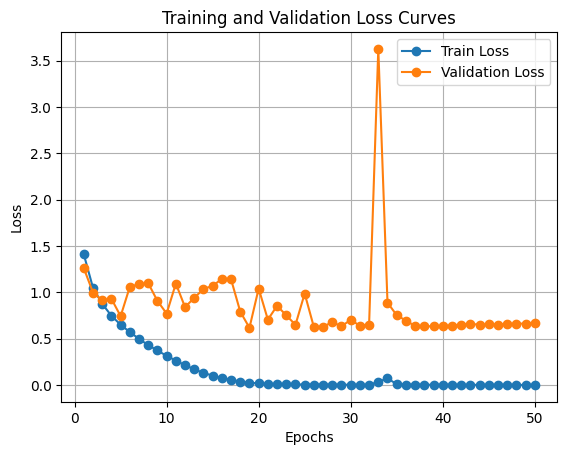

In [9]:
import matplotlib.pyplot as plt
# Plot the training and validation loss curve
plt.plot(range(1, total_epoch + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, total_epoch + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## Make prediction on test images

['cat' 'dog' 'frog' ... 'plane' 'dog' 'bird']


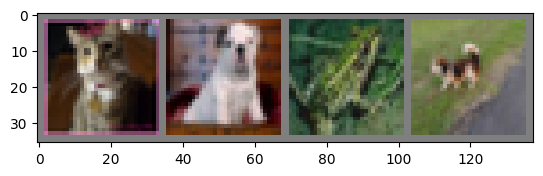

,label
0,cat
1,dog
2,frog
3,dog
4,truck
...,...
4995,deer
4996,ship
4997,plane
4998,dog


In [10]:
# since now we're testing (not training), we set no_grad to NOT calculate the gradients
with torch.no_grad():
    test_images = test_images.to(device)
    # calculate outputs by running images through the network
    outputs = model(test_images)
    # the class with the highest probability is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted = np.array([classes[i] for i in predicted])

print(predicted)
# show images
imshow(torchvision.utils.make_grid(test_images[:4]))

submission = pd.DataFrame()
submission['label'] = predicted
submission.to_csv("BatchNorm_50_SGD_n2_val.csv", index=True, index_label='id')
submission